# Vegetation detection

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import sys
sys.path.append("../common/")

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
from data_utils import TRAIN_IMAGE_IDS, LABELS
from image_utils import get_image_data, TRAIN_TILES, TRAIN_LABEL_TILES, get_image_tile_data, compute_mean_std_on_set
from visu_utils import display_img_1b, display_labels

In [4]:
import cv2
import numpy as np
np.random.seed(2017)

### Input data

Images of shape (512, 512, 17) 

In [5]:
from unet import unet_one_test

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release.  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 750 Ti (CNMeM is enabled with initial size: 85.0% of memory, cuDNN 4007)


Keras user configuration is setup


In [6]:
for i, l in enumerate(LABELS):
    print i, l

0 None
1 Buildings
2 Misc. Manmade structures
3 Road
4 Track
5 Trees
6 Crops
7 Waterway
8 Standing water
9 Vehicle Large
10 Vehicle Small


In [7]:
# RESIZE_TILES = False
# # tile_size = (512, 512)
# tile_size = (128, 128)
# n_channels = 17
# model = unet_zero(len(LABELS)-1, n_channels, *tile_size)

In [8]:
from glob import glob
all_train_tiles = glob(os.path.join(TRAIN_TILES, "*.tif"))
all_train_tiles = np.array([s[len(TRAIN_TILES)+1:] for s in all_train_tiles])
print "First train tile : ", all_train_tiles[0]

if False:

    from sklearn.model_selection import train_test_split 

    # TRAIN ON N TILES
    n_tiles = -1
    if n_tiles > 0:
        train_tiles, val_tiles = train_test_split(all_train_tiles[:n_tiles], test_size=0.3)
    else:
        train_tiles, val_tiles = train_test_split(all_train_tiles, test_size=0.3)

    print "Train/Test : ", len(train_tiles), len(val_tiles)
    
    logging.getLogger().setLevel(logging.INFO)
    mean_tile_image, std_tile_image = compute_mean_std_on_set(train_tiles)
    logging.getLogger().setLevel(logging.WARN)
    
else:
    ll = int(len(all_train_tiles)*0.7)
    train_tiles = all_train_tiles[:ll]
    val_tiles = all_train_tiles[ll:]
    
    mean_tile_fname = os.path.join(TRAIN_TILES, 'mean_tile_image.npz')
    std_tile_fname = os.path.join(TRAIN_TILES, 'std_tile_image.npz')
    if not os.path.exists(mean_tile_fname) or not os.path.exists(std_tile_fname):
        logging.getLogger().setLevel(logging.INFO)
        mean_tile_image, std_tile_image = compute_mean_std_on_set(train_tiles)
        logging.getLogger().setLevel(logging.WARN)
        np.savez(mean_tile_fname, mean_tile_image)
        np.savez(std_tile_fname, std_tile_image)
    else:
        mean_tile_image = np.load(mean_tile_fname)['arr_0']
        std_tile_image = np.load(std_tile_fname)['arr_0']
        
    print mean_tile_image.shape, std_tile_image.shape

First train tile :  6010_1_2_0_0.tif
(256L, 256L, 17L) (256L, 256L, 17L)


In [9]:
def normalize_image(img_data, mean_image=None, std_image=None):
    out = img_data.astype(np.float32)    
    if mean_image is not None or std_image is not None:
        out -= mean_image 
        out /= std_image
    out = out.transpose([2,0,1])
    return out


def generate_images(train_tiles, batch_size, print_tile_id=False):
    while True:
        n = len(train_tiles)
        n_batches = n // batch_size
        random_indices = np.arange(n)
        np.random.shuffle(random_indices)
        for i in range(n_batches):
            end = min((i+1)*batch_size, n) 
            batch_indices = random_indices[batch_size*i:end]
            X = np.zeros((batch_size, n_channels)+tile_size, dtype=np.float32)
            Y = np.zeros((batch_size, n_labels)+tile_size, dtype=np.float32)
            for j, tile_id in enumerate(train_tiles[batch_indices]):
                if print_tile_id:
                    print("Tile id: %s" % tile_id)
                x = get_image_tile_data(os.path.join(TRAIN_TILES,tile_id))
                y = get_image_tile_data(os.path.join(TRAIN_LABEL_TILES,tile_id))
                
                if n_labels < len(LABELS) - 1:
                    y = y[:,:,labels]
                if n_channels < 17:
                    x = x[:,:,channels]

                x = normalize_image(x, mean_tile_image[:,:,channels], std_tile_image[:,:,channels])
                y = normalize_image(y)     
                
                X[j,:,:,:] = x
                Y[j,:,:,:] = y 
                
            yield (X, Y)

In [ ]:
batch_size = 5
for X, Y in generate_images(train_tiles, batch_size, print_tile_id=True):
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()
    
    for i in range(batch_size):
        plt.figure(figsize=(14, 6))
        n, m = 3, int(n_channels * 1.0 / 3.0 + 0.5), 
        for j in range(n_channels):
            plt.subplot(n,m,j+1)
            display_img_1b(X[i,j,:,:])
            plt.title("Channels %i" % j)
                
        plt.figure(figsize=(14, 6))    
        if n_labels < 8:
            n, m = 1, n_labels
        else:
            n, m = 3, int(n_labels * 1.0 / 3.0 + 0.5), 
        for j in range(n_labels):
            plt.subplot(n, m,j+1)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label : %s" % LABELS[labels[j]])

    break

In [10]:
import os
from keras.optimizers import Adam, Nadam, SGD, Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from metrics import jaccard_coef, jaccard_coef_int

In [24]:
tile_size = (256, 256)
# channels = np.array(range(17))
channels = np.array([0, 1, 2, 3, 4])
n_channels = len(channels)

# labels = np.array(range(len(LABELS)))
labels = np.array([0, 5, 6, 2])
n_labels = len(labels)

deep=False 
n_filters_0=8

model = unet_one_test(n_labels, n_channels, *tile_size, deep=deep, n_filters_0=n_filters_0)

weights_filename = os.path.join("weights", "unet_one_test_%i_%i_%s_%i.h5.store" % (n_channels, n_labels, str(deep), n_filters_0))
if os.path.exists(weights_filename):
    print "Found weights file %s" % weights_filename
    model.load_weights(weights_filename)

In [25]:
channels, labels, np.array(LABELS)[labels]

(array([0, 1, 2, 3, 4]),
 array([0, 5, 6, 2]),
 array(['None', 'Trees', 'Crops', 'Misc. Manmade structures'], 
       dtype='|S24'))

In [26]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 5, 256, 256)   0                                            
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 8, 256, 256)   368         input_3[0][0]                    
____________________________________________________________________________________________________
convolution2d_8 (Convolution2D)  (None, 8, 256, 256)   368         input_3[0][0]                    
____________________________________________________________________________________________________
merge_3 (Merge)                  (None, 8, 256, 256)   0           convolution2d_7[0][0]            
                                                                   convolution2d_8[0][0]   

In [27]:
if not os.path.exists('weights'):
    os.mkdir('weights')
    
model_checkpoint = ModelCheckpoint(weights_filename, monitor='loss', save_best_only=True)
# earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0)
# LearningRateScheduler

In [28]:
# model.compile(optimizer=Nadam(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
# model.compile(optimizer=Nadam(lr=0.001), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

# model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
# model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

# sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

model.compile(optimizer=Adadelta(lr=0.001), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

We have 25 images splitted into 64 tiles. It gives 1600 tiles to train on.
Train/test split with test size 0.3 gives: 1120 and 480 number of tiles.
Assembling 32 tiles in a batch, we obtain 35 batches for training tiles and 15 batches for validation.

In [29]:
# from keras.callbacks import RemoteMonitor
# rmon = RemoteMonitor(root='http://localhost:9000', path='/publish/epoch/end/', field='data', headers={'Content-Type': 'application/json', 'Accept': 'application/json'})

In [43]:
foo = lambda x: max(x // 10, min(batch_size * 10, x))

batch_size = 16
samples_per_epoch = foo(len(train_tiles))
nb_val_samples = foo(len(val_tiles))


print batch_size, samples_per_epoch, nb_val_samples

history = model.fit_generator(
    generate_images(train_tiles, batch_size),
    samples_per_epoch=samples_per_epoch, 
    nb_epoch=20,
    validation_data=generate_images(val_tiles, batch_size),
    nb_val_samples=nb_val_samples,
    callbacks=[model_checkpoint],
    verbose=2
)

16 160 160
Epoch 1/20
37s - loss: 337.6370 - jaccard_coef: 0.1667 - jaccard_coef_int: 0.2253 - acc: 0.0450 - val_loss: 342.2373 - val_jaccard_coef: 0.1950 - val_jaccard_coef_int: 0.2327 - val_acc: 0.0869
Epoch 2/20
23s - loss: 334.2657 - jaccard_coef: 0.1679 - jaccard_coef_int: 0.2390 - acc: 0.0527 - val_loss: 338.2127 - val_jaccard_coef: 0.2012 - val_jaccard_coef_int: 0.2297 - val_acc: 0.1069
Epoch 3/20
22s - loss: 331.6730 - jaccard_coef: 0.1771 - jaccard_coef_int: 0.2487 - acc: 0.0501 - val_loss: 336.6095 - val_jaccard_coef: 0.1918 - val_jaccard_coef_int: 0.2277 - val_acc: 0.0943
Epoch 4/20
14s - loss: 334.6001 - jaccard_coef: 0.1737 - jaccard_coef_int: 0.2447 - acc: 0.0353 - val_loss: 343.0285 - val_jaccard_coef: 0.2010 - val_jaccard_coef_int: 0.2337 - val_acc: 0.0976
Epoch 5/20
13s - loss: 336.5119 - jaccard_coef: 0.1666 - jaccard_coef_int: 0.2224 - acc: 0.0532 - val_loss: 333.6591 - val_jaccard_coef: 0.1904 - val_jaccard_coef_int: 0.2293 - val_acc: 0.0893
Epoch 6/20
13s - loss: 3

If `nan` appears, analyse a single image model fit

In [42]:
batch_size = 10
for X, Y in generate_images(train_tiles, batch_size, print_tile_id=True):
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()

    hist = model.fit(X, Y, batch_size=batch_size//2, nb_epoch=5, verbose=2)
    Y_pred = model.predict(X, batch_size=batch_size//2)
    print Y_pred.min(), Y_pred.max()
    break

Tile id: 6100_2_3_1280_1280.tif
Tile id: 6110_1_2_384_0.tif
Tile id: 6110_3_1_1728_0.tif
Tile id: 6110_1_2_384_2624.tif
Tile id: 6040_1_0_3072_832.tif
Tile id: 6040_4_4_2176_832.tif
Tile id: 6040_1_0_1280_2624.tif
Tile id: 6110_4_0_2176_384.tif
Tile id: 6040_1_3_0_832.tif
Tile id: 6100_1_3_0_384.tif
(10L, 5L, 256L, 256L) (10L, 4L, 256L, 256L)
-0.0523368 0.268985 0.0 1.0
Epoch 1/5
0s - loss: 314.2312 - jaccard_coef: 0.1649 - jaccard_coef_int: 0.2099 - acc: 0.0235
Epoch 2/5
0s - loss: 313.6618 - jaccard_coef: 0.1646 - jaccard_coef_int: 0.2246 - acc: 0.0235
Epoch 3/5
0s - loss: 313.6932 - jaccard_coef: 0.1578 - jaccard_coef_int: 0.2230 - acc: 0.0235
Epoch 4/5
0s - loss: 313.7639 - jaccard_coef: 0.1627 - jaccard_coef_int: 0.2216 - acc: 0.0236
Epoch 5/5
0s - loss: 314.2064 - jaccard_coef: 0.1653 - jaccard_coef_int: 0.2133 - acc: 0.0236
0.0 1.0


In [38]:
layer = model.get_layer(index=2)
print layer.weights
print layer.W.eval()[0,0,:,:]

layer = model.get_layer(index=1)
print layer.weights
print layer.W.eval()[0,0,:,:]
layer = model.get_layer(index=5)
print layer.weights
print layer.W.eval()[0,0,:,:]

[convolution2d_8_W, convolution2d_8_b]
CudaNdarray([[ 0.17589116  0.20729892  0.18994068]
 [ 0.01797736  0.17344907  0.06074642]
 [-0.34335557  0.01476775 -0.12704323]])
[convolution2d_7_W, convolution2d_7_b]
CudaNdarray([[ 0.0802094  -0.05721462 -0.37572011]
 [-0.29149053 -0.46739471  0.18357685]
 [-0.28455263  0.04730558 -0.09201641]])
[convolution2d_9_W, convolution2d_9_b]
CudaNdarray([[ 0.20408738]])


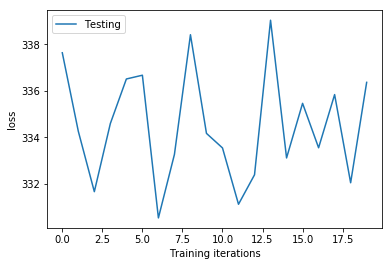

In [45]:
# plt.plot(history.history['val_jaccard_coef_int'])
# plt.ylabel('Jaccard coeff integer')
# plt.plot(history.history['val_jaccard_coef'])
# plt.ylabel('Jaccard coeff')
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('Training iterations')
plt.legend(['Testing'], loc='upper left')
plt.show()

In [ ]:
def _plot(X, Y, Y_pred, i, c=1):
    plt.figure(figsize=(12,6))
    plt.subplot(131)
    display_img_1b(X[i,0,:,:])
    plt.subplot(132)
    display_img_1b(Y[i,c,:,:])
    plt.subplot(133)
    display_img_1b(Y_pred[i,c,:,:])

(5L, 4L, 256L, 256L) 1.51859e-21 1.0


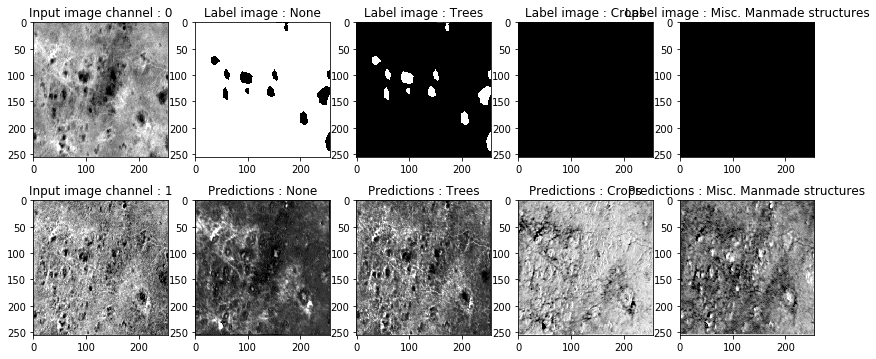

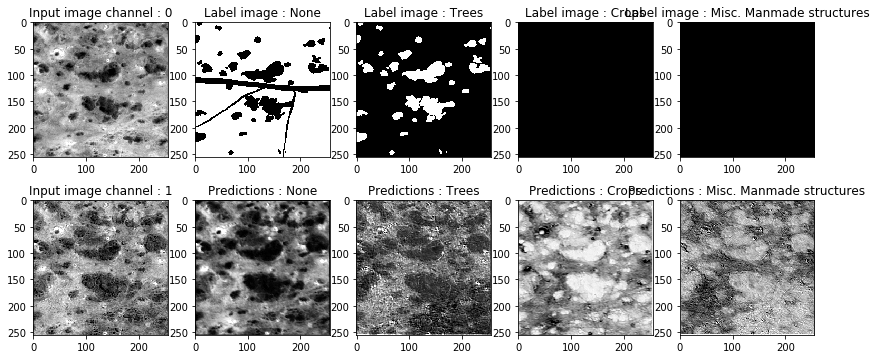

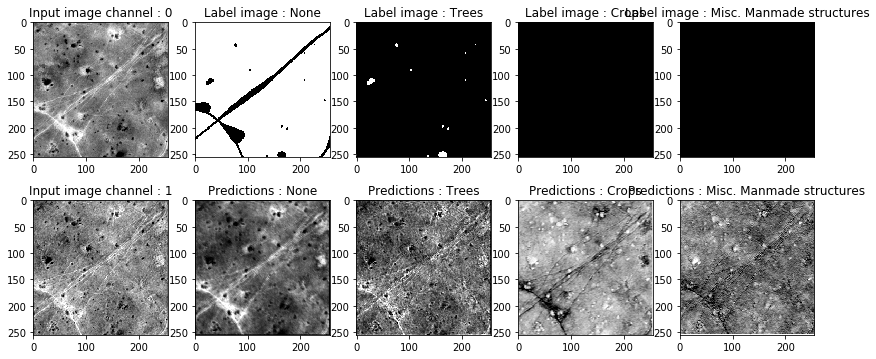

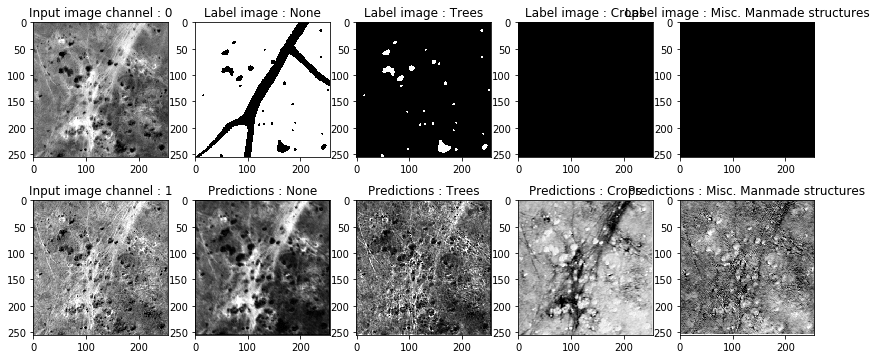

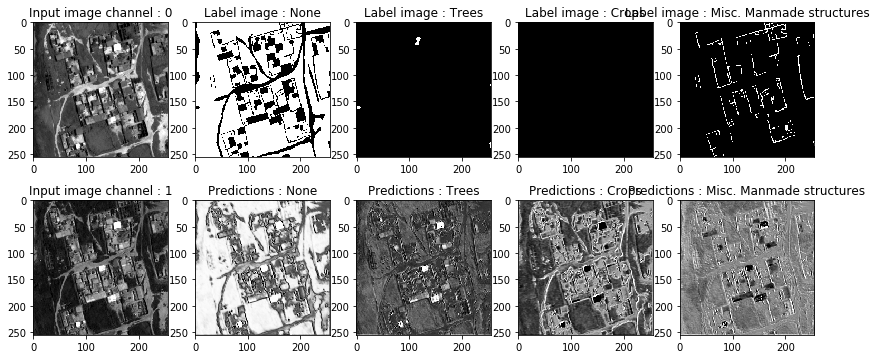

In [46]:
batch_size = 5

for X, Y in generate_images(train_tiles, batch_size):
    Y_pred = model.predict_on_batch(X)
    print Y_pred.shape, Y_pred.min(), Y_pred.max()

#     for i in range(batch_size):
#         _plot(X, Y, Y_pred, i)
#     print jaccard_coef(Y, Y_pred), jaccard_coef_int(Y, Y_pred)

    for i in range(batch_size):
        plt.figure(figsize=(14, 6))    
        plt.subplot(2,n_labels+1,1)
        display_img_1b(X[i,0,:,:])
        plt.title("Input image channel : %i" % 0)
        for j in range(n_labels):
            plt.subplot(2,n_labels+1,j+2)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label image : %s" % LABELS[labels[j]])
        
        plt.subplot(2,n_labels+1,j+3)
        display_img_1b(X[i,1,:,:])   
        plt.title("Input image channel : %i" % 1)
        for jj in range(n_labels):
            plt.subplot(2,n_labels+1,jj+j+4)
            display_img_1b(Y_pred[i,jj,:,:])
            plt.title("Predictions : %s" % LABELS[labels[jj]])

    break


In [ ]:
_plot(X, Y, Y_pred, 0, 0)

In [ ]:
y = Y_pred[0,2,:,:]
print y.min(), y.max()